In [1]:
# import data & visualization libraries
import os
# for tensorflow, XLA (Accelerated Linear Algebra) environment variable to enhance the performace on compatible devices
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import machine learning libraries
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
# set the random seed for consistent random number generation everytime
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# load data from CSV file, no header, single datastream, no labels in data
data = pd.read_csv('dataset.csv', header=None)

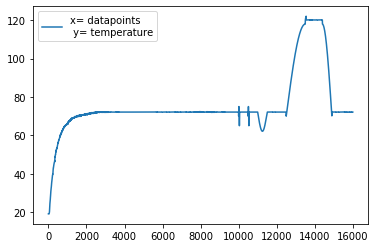

In [4]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [5]:
# split the data, first 10000 train, remaining 6000 test data
raw_train_data = data.iloc[:10000]
raw_test_data = data.iloc[10000:]

# verify the shape of the data; (col,row)
raw_train_data.shape, raw_test_data.shape #returns (rows, columns)

((10000, 1), (6000, 1))

In [6]:
# scale the overall range of the data to 1 std. deviation, useful for gradient computation by the optimizer
scaler = StandardScaler()
# calculate the 'mean' using fit method
scaler = scaler.fit(np.array(raw_train_data).reshape(-1,1))
# transform the mean into train & test data; reshape (number of samples, features)
train_data = scaler.transform(np.array(raw_train_data).reshape(-1,1))
test_data = scaler.transform(np.array(raw_test_data).reshape(-1,1))


In [7]:
### create sequence with timesteps, referred to as the lookback window or memory of the model 
TIME_STEPS = 400

def create_sequences(dataset, time_steps=TIME_STEPS):
    
    # creates sequences from the input data with the given time steps
    X_out = []
    y_out = []
    for i in range(len(dataset) - time_steps):
        X_out.append(dataset[i:i+time_steps])
        y_out.append(dataset[i+time_steps])
    return np.array(X_out), np.array(y_out)

In [8]:
# create sequences with a specified number of time steps using the create_sequences function

X_train, y_train = create_sequences(train_data, TIME_STEPS)
X_test, y_test = create_sequences(test_data, TIME_STEPS)

# output format of X_train.shape, (number of timesteps, sample per timesteps, number of features)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (9600, 400, 1)
Testing input shape:  (5600, 400, 1)


In [9]:
# Define LSTM autoencoder model
# linear stack of layers
model = Sequential()
# LSTM layer with 64 units, timesteps number of samples and 1 feature
model.add(LSTM(64, input_shape=(TIME_STEPS, 1)))
# repeat the representation from the previous layer timesteps times for decoding
model.add(RepeatVector(TIME_STEPS))
# feed the representation to 64 LSTM units to generate the input sequence
model.add(LSTM(64, return_sequences=True))
# produce a single output value for each time step of the input sequence
model.add(TimeDistributed(Dense(1)))
# compile with adam optimizer, tune learning rate to minize 'mse'
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [10]:
### check execution time of cell, variable for different hardware & software setups
start_time = datetime.now()

# Train the model and save the history
history = model.fit(X_train, X_train, epochs=16, batch_size=500, validation_data=(X_test, X_test), verbose=1,)

end_time = datetime.now()
exec_time = end_time-start_time
print ("Execution time is: (H:MM:SS.ms)" )
print(exec_time)

Epoch 1/16
20/20 [==============================] - 44s 2s/step - loss: 0.3940 - val_loss: 9.9792
Epoch 2/16
20/20 [==============================] - 43s 2s/step - loss: 0.2821 - val_loss: 8.7119
Epoch 3/16
20/20 [==============================] - 45s 2s/step - loss: 0.1671 - val_loss: 8.0879
Epoch 4/16
20/20 [==============================] - 43s 2s/step - loss: 0.0763 - val_loss: 8.1504
Epoch 5/16
20/20 [==============================] - 43s 2s/step - loss: 0.0600 - val_loss: 8.2822
Epoch 6/16
20/20 [==============================] - 44s 2s/step - loss: 0.0555 - val_loss: 8.2439
Epoch 7/16
20/20 [==============================] - 44s 2s/step - loss: 0.0524 - val_loss: 8.2298
Epoch 8/16
20/20 [==============================] - 44s 2s/step - loss: 0.0503 - val_loss: 8.2105
Epoch 9/16
20/20 [==============================] - 44s 2s/step - loss: 0.0485 - val_loss: 8.1614
Epoch 10/16
20/20 [==============================] - 43s 2s/step - loss: 0.0472 - val_loss: 8.1079
Epoch 11/16
20/20 [

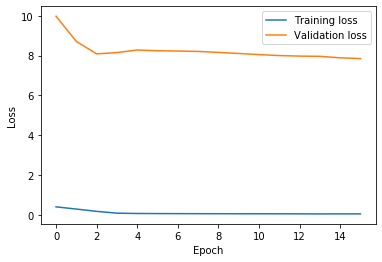

In [11]:
### Plot Training - Validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
### check execution time of cell, variable for different hardware & software setups
start_time = datetime.now()

# Make predictions on the train dataset
X_train_pred = model.predict(X_train, verbose=1)

end_time = datetime.now()
exec_time = end_time-start_time
print ("Execution time is: (H:MM:SS.ms)" )
print(exec_time)

300/300 [==============================] - 30s 100ms/step
Execution time is: (H:MM:SS.ms)
0:00:30.982999


In [13]:
# calculate MAE loss on the train dataset, the difference between predicted value & actual value
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)


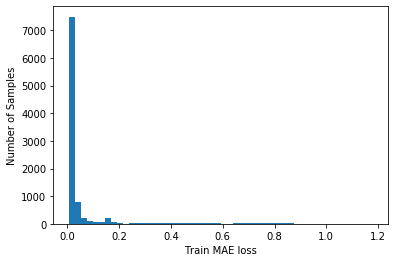

In [14]:
# visualize MAE loss on the train dataset
# bins = divide the entire range in n numbers before plotting
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
### check execution time of cell, variable for different hardware & software setups
start_time = datetime.now()

# make predictions on the test dataset
X_test_pred = model.predict(X_test, verbose=1)

end_time = datetime.now()
exec_time = end_time-start_time
print ("Execution time is: (H:MM:SS.ms)" )
print(exec_time)

175/175 [==============================] - 18s 100ms/step
Execution time is: (H:MM:SS.ms)
0:00:17.624773


In [16]:
# Calculate MAE loss on the test dataset, the difference between predicted value & actual value
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

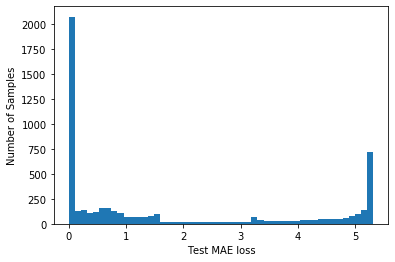

In [17]:
# Visualize MAE loss on the test dataset
# bins = divide the entire range in n numbers before plotting
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# Set the threshold for anomaly detection
# threshold = 0.5, set threshold for debugging
# 3 * np.std to cover 99% of the data of the training dataset
threshold = np.mean(train_mae_loss) + 3 * np.std(train_mae_loss)

In [19]:
# check threshold for debugging
threshold

0.516266141760315

In [20]:
# pandas dataframe to array conversion
# convert raw_test_data.to_numpy() array to fit in the table
sensor_data = raw_test_data.to_numpy()

# Create anomaly dataframe
anomaly_df = pd.DataFrame(columns=['Timesteps', 'Sensor_data', 'Test_loss', 'Threshold', 'Anomaly'])

# Add data to the anomaly dataframe
# output the range only, excluding the first timestep range (400, 6000) in this case
anomaly_df['Timesteps'] = range(TIME_STEPS, len(sensor_data))
# sensor data ecxluding the first timestep window data
anomaly_df['Sensor_data'] = sensor_data[TIME_STEPS:]
# the calculated loss for the corresponding test data
anomaly_df['Test_loss'] = test_mae_loss

# Add the threshold column to the anomaly dataframe
anomaly_df['Threshold'] = threshold

# Find the anomalous data points (binary output)
anomaly_df['Anomaly'] = anomaly_df['Test_loss'] > anomaly_df['Threshold']

In [21]:
# verify the dataframe
anomaly_df.head()

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,400,72.121361,0.060126,0.516266,False
1,401,72.121368,0.060769,0.516266,False
2,402,72.121399,0.061231,0.516266,False
3,403,72.121429,0.061488,0.516266,False
4,404,72.118942,0.061544,0.516266,False


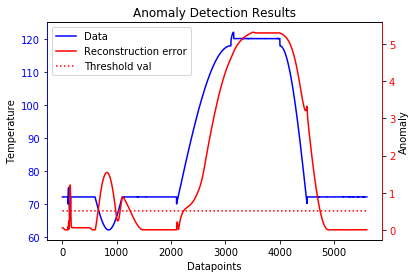

In [22]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
# twinx() for multiple Y axis plots
ax2 = ax1.twinx()

# set colors for the plot
color1 = 'blue'
color2 = 'red'

# plot the data from anomaly_df, 3 different lines dor 3 different parameters
line1 = ax1.plot(anomaly_df.index, anomaly_df['Sensor_data'], color=color1, label = 'Data')
line2 = ax2.plot(anomaly_df.index, anomaly_df['Test_loss'], color=color2, label = 'Reconstruction error')
line3 = ax2.plot(anomaly_df.index, anomaly_df['Threshold'], color=color2, linestyle = 'dotted', label = 'Threshold val')

# set titles & labels
plt.title('Anomaly Detection Results')
ax1.set_xlabel('Datapoints')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

# further tweaking the spines & tick_params (optional)
ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

# code to plot the legends, for loop for plotting lables in next lines else the lables will be superimposed
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "upper left")

plt.show()


In [23]:
# check and verify the anomaly region
anomaly_df.head(3333)

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,400,72.121361,0.060126,0.516266,False
1,401,72.121368,0.060769,0.516266,False
2,402,72.121399,0.061231,0.516266,False
3,403,72.121429,0.061488,0.516266,False
4,404,72.118942,0.061544,0.516266,False
...,...,...,...,...,...
3328,3728,120.128662,5.158370,0.516266,True
3329,3729,120.126694,5.159629,0.516266,True
3330,3730,120.138878,5.160882,0.516266,True
3331,3731,120.164886,5.162138,0.516266,True


In [24]:
# loop through the test_mae_loss to find the status of the data

# set the window size
window_size = 100

# set the anomaly threshold
anomaly_threshold = 5 * threshold

# initialize the moving window list
moving_window = []

# loop through the data in window_size intervals
for i in range(0, len(test_mae_loss), window_size):
    
    # get the current window data
    window_data = test_mae_loss[i:i+window_size]
    
    # calculate the mean of the current window
    window_mean = np.mean(window_data)
    
    # add the current window mean to the moving window
    moving_window.append(window_mean)
    
    # if the moving window contains more than 3 elements, remove the oldest element
    if len(moving_window) < 3:
        # Add the current window mean to the moving window
        moving_window.append(window_mean)
    
    # if the moving window contains 3 elements, remove the oldest element
    else:
    
        # check if the moving window's mean is less than the threshold
        if np.mean(moving_window) < threshold:
            status = "Normal"

        # check if the moving window's mean is greater than the threshold but less than the anomaly threshold
        elif threshold <= np.mean(moving_window) < anomaly_threshold:
            status = "Anomaly"

        # if the moving window's mean is greater than or equal to the anomaly threshold, mark as Fault
        else:
            status = "Fault"

        # print the status of the current window
        print(f"Status of moving_window {i//window_size+1} is {status}")

        # drop the first entry from the moving window
        moving_window.pop(0)

Status of moving_window 2 is Normal
Status of moving_window 3 is Normal
Status of moving_window 4 is Normal
Status of moving_window 5 is Normal
Status of moving_window 6 is Normal
Status of moving_window 7 is Normal
Status of moving_window 8 is Anomaly
Status of moving_window 9 is Anomaly
Status of moving_window 10 is Anomaly
Status of moving_window 11 is Anomaly
Status of moving_window 12 is Anomaly
Status of moving_window 13 is Anomaly
Status of moving_window 14 is Normal
Status of moving_window 15 is Normal
Status of moving_window 16 is Normal
Status of moving_window 17 is Normal
Status of moving_window 18 is Normal
Status of moving_window 19 is Normal
Status of moving_window 20 is Normal
Status of moving_window 21 is Normal
Status of moving_window 22 is Normal
Status of moving_window 23 is Normal
Status of moving_window 24 is Normal
Status of moving_window 25 is Anomaly
Status of moving_window 26 is Anomaly
Status of moving_window 27 is Anomaly
Status of moving_window 28 is Anomaly

In [25]:
# References
# https://stackoverflow.com/questions/65907365/tensorflow-not-creating-xla-devices-tf-xla-enable-xla-devices-not-set
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
# https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/
# https://www.youtube.com/watch?v=_TZC88plGZs
# https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc/44748370#44748370
# https://stackoverflow.com/questions/51914632/tensorflow-lstm-why-does-test-accuracy-become-low-but-not-training-one/51926223#51926223
# https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
# 
# 
# 
# 
# 